In [1]:
import numpy as np
import tensorflow as tf
import os
import json
import tqdm.notebook as tqdm
from gensim.models import Word2Vec, FastText
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [2]:
def read(path_with_everything: str):
    codes = []
    tags = []
    for contest_folder in os.listdir(path_with_everything):
        contest_path = os.path.join(path_with_everything, contest_folder)
        if not os.path.isdir(contest_path):
            continue
        meta_json = json.load(open(os.path.join(contest_path, 'meta.json'), 'r', encoding='utf-8'))
        submissions = meta_json['Submissions']
        for s in submissions.values():
            flattened_tree_path = os.path.join(contest_path, 'java', f'{s["Id"]}.java.ast.stm.flat')
            if not os.path.exists(flattened_tree_path):
                continue

            tags.append(s['Tags'])
            statements = open(flattened_tree_path, 'r', encoding='utf-8').read().strip('\n').split('\n\n')
            codes.append([])
            for stm in statements:
                codes[-1].append([])
                for i in stm.split('\n'):
                    try:
                        token, children = i.split('\t')
                        children = tuple(map(int, children.split())) if children else ()
                        codes[-1][-1].append((token, children))
                    except:
                        print(flattened_tree_path, stm, i, sep='\n\n')
    return codes, tags

In [3]:
codes, tags = read('utils/samples/Codeforces/Yoink-Data')

In [4]:
for code in codes:
    for statement in code:
        for node, children in statement:
            for child in children:
                _ = statement[child]

In [5]:
vocab = set()
for code in codes:
    for statement in code:
        for token, _ in statement:
            vocab.add(token)
len(vocab)

21777

In [7]:
vocab = list(vocab)
token_to_id = {j:i for i, j in enumerate(vocab)}

In [8]:
labels = set()
for tag_list in tags:
    for tag in tag_list:
        labels.add(tag)
labels = list(labels)
label_to_id = {label: i for i, label in enumerate(labels)}
labels

['greedy',
 'games',
 'geometry',
 'number theory',
 'constructive algorithms',
 'implementation',
 'data structures',
 'matrices',
 'hashing',
 'two pointers',
 'dfs and similar',
 'string suffix structures',
 'strings',
 'interactive',
 'graphs',
 'bitmasks',
 'flows',
 'sortings',
 'dsu',
 'divide and conquer',
 'combinatorics',
 'meet-in-the-middle',
 'brute force',
 'binary search',
 'math',
 'trees',
 'shortest paths',
 'dp']

In [9]:
dim = 192

In [10]:
w2v_model = Word2Vec.load('embeddings/java-full.w2v')
w2v_wv = w2v_model.wv
w2v_embeddings = np.array([w2v_wv[i] if i in w2v_wv else np.zeros((dim,)) for i in vocab])

In [11]:
ft_model = FastText.load('embeddings/java-full.ft')
ft_wv = ft_model.wv
ft_embeddings = np.array([ft_wv[i] if i in ft_wv else np.zeros((dim,)) for i in vocab])

In [11]:
print(w2v_embeddings[:10])
print(ft_embeddings[:10])

[[-0.06022203 -0.05019223  0.04593682 ...  0.04208384 -0.05751115
   0.05851987]
 [ 0.02017459 -0.03351881 -0.04652831 ...  0.01076053 -0.04776208
  -0.00217807]
 [-0.05902512 -0.0700544   0.04433153 ...  0.04996527 -0.02028089
   0.03779978]
 ...
 [-0.18601689  0.04202949 -0.01236789 ... -0.13376763  0.13610627
   0.13199934]
 [-0.08399533 -0.02169384 -0.00946767 ...  0.14841257 -0.0713061
   0.04922435]
 [-0.06672399 -0.07161798  0.04445332 ...  0.04945719 -0.05223358
   0.02746269]]
[[-0.01857372 -0.10895224  0.2549206  ... -0.12345928 -0.25181282
  -0.43457216]
 [ 0.58150953  0.72411364  0.18455549 ...  0.12400433 -0.50764745
  -1.0239046 ]
 [-0.11094207  0.46985316  0.6421311  ... -0.122959   -0.6020933
  -0.43584085]
 ...
 [ 0.48439214  0.41152203  0.6876699  ...  0.64055616 -1.1341507
  -0.22128752]
 [-0.66552     0.5478181   0.290268   ... -0.16786881 -0.61588895
  -0.9434139 ]
 [ 0.20900474 -0.21863729  0.398004   ... -0.09224632 -0.16981083
  -0.3688257 ]]


In [12]:
print(sum(i in w2v_wv for i in vocab), len(vocab))
print(sum(i in ft_wv for i in vocab), len(vocab))

21777 21777
21777 21777


In [13]:
print(len(w2v_model.wv.key_to_index))
print(len(ft_model.wv.key_to_index))

21777
21777


In [12]:
vectorized = []
indices = []
max_code_len = -1
max_statement_len = -1

statements_hist = []

for code in codes:
    vectorized.append([])
    indices.append([])
    max_code_len = max(max_code_len, len(code))
    statements_hist.append(len(code))
    for statement in code:
        vectorized[-1].append([])
        indices[-1].append([])
        max_statement_len = max(max_statement_len, len(statement))
        for token, _ in statement:
            vectorized[-1][-1].append(token_to_id[token] + 2)
            indices[-1][-1].append(_)

In [15]:
print(vectorized[:10])
print(indices[:10])

[[[16313, 10897, 10591, 10693], [1408, 10897, 10591, 142, 21532, 10591, 16801, 511, 10591, 15750, 2650], [19477, 511, 10591, 12714, 21172, 10591, 13062, 7700, 511, 10591, 12714, 8844, 5848, 7785, 21295, 10591, 20023], [19477, 19021, 10591, 12791, 21172, 10591, 3219], [4041, 7785, 13062, 10591, 18251], [19477, 19021, 10591, 12791, 21172, 10591, 1415], [4041, 7785, 13062, 10591, 18251], [19477, 19021, 10591, 21464, 21172, 10591, 9756, 3257, 19021, 10591, 12791, 20256, 15289, 10680, 5848, 10591, 3219, 21635, 8083, 21009], [13411, 15774, 9344, 19021, 10591, 12791, 21172, 10591, 7545, 21635, 8083, 12421, 20256, 15289, 15202, 5848, 10591, 7545, 5848, 10591, 3219, 5848, 10591, 7545, 20727, 5872, 15289, 19990, 740], [11264, 19655, 15289, 9086, 5848, 10591, 9756, 21463, 5848, 10591, 7545], [4041, 7785, 13062, 10591, 18251], [11264, 19655, 15289, 9086, 5848, 10591, 9756, 21463, 21635, 8083, 8355, 21635, 8083, 8355], [11264, 19655, 15289, 9086, 5848, 10591, 9756, 21463, 20256, 15289, 10680, 5848,

(array([2.397e+03, 4.667e+03, 1.836e+03, 1.633e+03, 1.436e+03, 1.000e+03,
        7.240e+02, 6.220e+02, 5.450e+02, 4.710e+02, 4.130e+02, 3.460e+02,
        3.220e+02, 2.170e+02, 2.060e+02, 1.950e+02, 1.660e+02, 1.400e+02,
        9.300e+01, 1.040e+02, 7.200e+01, 9.000e+01, 6.200e+01, 5.400e+01,
        4.100e+01, 4.200e+01, 2.600e+01, 2.100e+01, 1.400e+01, 4.100e+01,
        2.600e+01, 1.500e+01, 1.600e+01, 8.000e+00, 4.000e+00, 7.000e+00,
        9.000e+00, 1.000e+01, 2.000e+00, 3.000e+00, 7.000e+00, 2.000e+00,
        0.000e+00, 6.000e+00, 4.000e+00, 4.000e+00, 3.000e+00, 3.000e+00,
        9.000e+00, 5.000e+00, 4.000e+00, 1.000e+00, 3.000e+00, 1.000e+00,
        5.000e+00, 5.000e+00, 2.000e+00, 3.000e+00, 1.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 6.000e+00, 0.000e+0

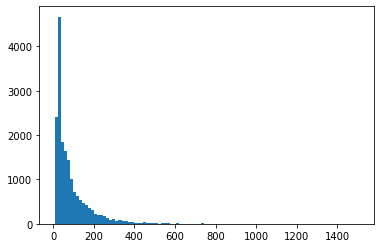

In [16]:
import matplotlib.pyplot as plt

plt.hist(statements_hist, bins=100)

In [17]:
print(np.mean(statements_hist))

87.34759887782606


In [13]:
he_tags = []
for tag_list in tags:
    he_tags.append([0] * len(labels))
    for tag in tag_list:
        he_tags[-1][label_to_id[tag]] = 1
he_tags = np.array(he_tags)

In [19]:
print(he_tags[:10])

[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1]]


In [20]:
print(max_code_len)
print(max_statement_len)

1507
2019


In [21]:
# emb_size = 192
# input_dim = len(vocab) + 2
# weights = np.zeros((input_dim, emb_size))
#
# for i, token in enumerate(vocab):
#     try:
#         weights[i + 2] = ft_embeddings[i]
#     except:
#         pass
#
# embedding = tf.keras.layers.Embedding(input_dim, emb_size, name='Tree_Embedding', mask_zero=True)
# embedding.build((None, None, None))
# embedding.set_weights([weights])
# embedding.trainable = False

In [22]:
# encoder_dim = 128
# encoder_inputs = tf.keras.layers.Input((None, None, emb_size))
# encoder = tf.keras.layers.Dense(encoder_dim)(encoder_inputs)
# encoder_model = tf.keras.Model(inputs=encoder_inputs, outputs=encoder, name='Embedding_Encoder')

In [23]:
# inputs = tf.keras.layers.Input((None, None, encoder_dim))
# x = tf.keras.layers.Conv1D(filters=encoder_dim, kernel_size=3, activation='relu', padding='same')(inputs)
# x = tf.keras.layers.Conv1D(filters=encoder_dim, kernel_size=3, activation='relu', padding='same')(x)
# x = tf.keras.layers.Lambda(lambda x: tf.math.reduce_max(x, axis=2))(x)
# statement_encoder_model = tf.keras.Model(inputs=inputs, outputs=x, name='Statement_Encoder')

In [24]:
# inputs = tf.keras.layers.Input((None, encoder_dim), name='Inputs')
# x = tf.keras.layers.Dropout(0.1, name='Embedding_Dropout')(inputs)
# x = tf.keras.layers.Bidirectional(
#         tf.keras.layers.RNN(
#             tf.keras.layers.StackedRNNCells([
#             tf.keras.layers.GRUCell(units=256),
#             tf.keras.layers.GRUCell(units=256),
#         ])), name='Double_Bidirectional_GRU')(x)
# tree_encoder = tf.keras.models.Model(inputs=inputs, outputs=x, name='Tree_Encoder')

In [25]:
# inputs = tf.keras.layers.Input((None, None), name='Statement_Trees')
# x = embedding(inputs)
# x = encoder_model(x)
# x = statement_encoder_model(x)
# x = tree_encoder(x)
# x = tf.keras.layers.Dense(units=256, activation=tf.keras.activations.swish, name='Dense')(x)
# x = tf.keras.layers.Dense(units=len(labels), activation='sigmoid', name='Prediction')(x)
# combined_model = tf.keras.models.Model(inputs=inputs, outputs=x, name='PSLNN')
# combined_model.summary()
# combined_model.compile(optimizer='adam', loss='categorical_crossentropy')

In [36]:
emb_size = 192
input_dim = len(vocab) + 2
weights = np.zeros((input_dim, emb_size))

for i, token in enumerate(vocab):
    try:
        weights[i + 2] = w2v_embeddings[i]
    except:
        pass

embedding = tf.keras.layers.Embedding(input_dim, emb_size, name='Tree_Embedding', mask_zero=True)
embedding.build((None, None))
embedding.set_weights([weights])
embedding.trainable = False

In [35]:
inputs = tf.keras.layers.Input((None, ), dtype=tf.int32, name='token_input')
embedded = embedding(inputs)
dropout = tf.keras.layers.Dropout(0.5, name='embedding_dropout')(embedded)

n_layers = 2
kernels = [3, 5, 7]
layers = []

for k in kernels:
    x = dropout
    n = x.shape[-1]
    for i in range(n_layers):
        x = tf.keras.layers.Conv1D(n, k, activation=tf.keras.activations.swish, padding='same', name=f'conv1d_{k}_{n}')(x)
        x = tf.keras.layers.BatchNormalization(name=f'batch_norm_{k}_{n}')(x)
        n *= 2

    x = tf.keras.layers.GlobalMaxPooling1D(name=f'max_pool_{k}')(x)
    layers.append(x)

x = tf.keras.layers.Concatenate(axis=-1, name='pool_concatenate')(layers)
x = tf.keras.layers.Dropout(0.5, name='concatenate_dropout')(x)
x = tf.keras.layers.Dense(units=512, activation=tf.keras.activations.swish, name=f'dense_1')(x)
x = tf.keras.layers.Dense(units=len(labels), activation='sigmoid', name='prediction')(x)
model = tf.keras.models.Model(inputs=inputs, outputs=x, name='multilabel_model')
model.compile(optimizer='adam', loss='categorical_crossentropy')
model.summary()

Model: "multilabel_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
token_input (InputLayer)        [(None, None)]       0                                            
__________________________________________________________________________________________________
Tree_Embedding (Embedding)      (None, None, 192)    4181568     token_input[0][0]                
__________________________________________________________________________________________________
embedding_dropout (Dropout)     (None, None, 192)    0           Tree_Embedding[1][0]             
__________________________________________________________________________________________________
conv1d_3_192 (Conv1D)           (None, None, 192)    110784      embedding_dropout[0][0]          
___________________________________________________________________________________

In [34]:
class Dataset(tf.keras.utils.Sequence):
    def __init__(self, vectorized, indices, he_tags, batch_size):
        self.vectorized = vectorized
        self.indices = indices
        self.he_tags = he_tags
        self.batch_size = batch_size

    def __len__(self):
        return (len(self.vectorized) + self.batch_size - 1) // self.batch_size

    def __getitem__(self, idx):
        start = idx * self.batch_size
        end = (idx + 1) * self.batch_size
        vectorized_batch = vectorized[start:end]
        vectorized_batch = [[st for sequence in code for st in sequence] for code in vectorized_batch]
        indices_batch = indices[start:end]
        he_tags_batch = he_tags[start:end]
        # max_len = max(len(j) for i in vectorized_batch for j in i)
        # max_len = min(max_len, 256)
        code_batch = tf.keras.preprocessing.sequence.pad_sequences(vectorized_batch, maxlen=1024, padding='post')
        #     [tf.keras.preprocessing.sequence.pad_sequences(i, padding='post', maxlen=max_len) for i in vectorized_batch],
        #     padding='post'
        # )
        # code_batch = code_batch[:,:256]
        return code_batch, he_tags_batch

    def on_epoch_end(self):
        pass

dataset = Dataset(vectorized, indices, he_tags, batch_size=8)

In [17]:
dataset[0]

(array([[19654, 18308,  9662, ...,     0,     0,     0],
        [19654, 18308,  9662, ...,     0,     0,     0],
        [19654, 18308,  9662, ...,     0,     0,     0],
        ...,
        [10035,  9662,   485, ..., 19795,  9662, 14454],
        [10035,  9662,   485, ..., 19795,  9662, 14454],
        [19654, 18308,  9662, ...,     0,     0,     0]]),
 array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0

In [38]:
model.fit(dataset, epochs=1)

  49/2273 [..............................] - ETA: 1:18 - loss: 7942.6953

KeyboardInterrupt: 

In [ ]:
model.predict_on_batch(dataset[0][0])

In [ ]:
def batch(lst, n):
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

def recursive_encoding(epochs: int, batch_size: int):
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam()

    for epoch in tqdm.trange(epochs):
        vectorized_batches = batch(vectorized, batch_size)
        indices_batches = batch(indices, batch_size)
        he_tags_batches = batch(he_tags, batch_size)
        pbar = tqdm.tqdm(enumerate(zip(vectorized_batches, indices_batches, he_tags_batches)), total=len(vectorized) // batch_size)
        for step, (vectorized_batch, indices_batch, he_tags_batch) in pbar:
            max_len = max(len(j) for i in vectorized_batch for j in i)
            code_batch = tf.keras.preprocessing.sequence.pad_sequences(
                [tf.keras.preprocessing.sequence.pad_sequences(i, padding='post', maxlen=max_len) for i in vectorized_batch],
                padding='post'
            )
            with tf.GradientTape() as tape:
                # m: max_len
                # code_batch: b x n x m
                # encoded: b x n x m x e
                encoded = encoder_model(embedding(code_batch), training=True)
                encoded_as_list = [[[encoded[i, j, k] for k in range(max_len)] for j in range(code_batch.shape[1])] for i in range(len(code_batch))]
                for i in range(len(indices_batch)):
                    for j in range(len(indices_batch[i])):
                        for k in range(len(indices_batch[i][j]) - 1, -1, -1):
                            children = indices_batch[i][j][k]
                            if not children:
                                continue
                            encoded_as_list[i][j][k] = tf.reduce_sum([
                                encoded_as_list[i][j][k],
                                *(encoded_as_list[i][j][l] for l in children)
                            ], axis=0)

                pooled = tf.math.reduce_max(encoded_as_list, axis=2)
                logits = tree_encoder(pooled, training=True)
                loss_value = loss_fn(he_tags_batch, logits)

            #grads = tape.gradient(loss_value, model.trainable_weights + encoder_model.trainable_weights)
            #optimizer.apply_gradients(zip(grads, model.trainable_weights + encoder_model.trainable_weights))
            pbar.set_description(str(loss_value.numpy()))

In [ ]:
def statement_encoding(epochs: int, batch_size: int):
    loss_fn = tf.keras.losses.CategoricalCrossentropy()
    optimizer = tf.keras.optimizers.Adam()

    for epoch in tqdm.trange(epochs):
        vectorized_batches = batch(vectorized, batch_size)
        indices_batches = batch(indices, batch_size)
        he_tags_batches = batch(he_tags, batch_size)
        pbar = tqdm.tqdm(enumerate(zip(vectorized_batches, indices_batches, he_tags_batches)), total=len(vectorized) // batch_size)
        for step, (vectorized_batch, indices_batch, he_tags_batch) in pbar:
            max_len = max(len(j) for i in vectorized_batch for j in i)
            code_batch = tf.keras.preprocessing.sequence.pad_sequences(
                [tf.keras.preprocessing.sequence.pad_sequences(i, padding='post', maxlen=max_len) for i in vectorized_batch],
                padding='post'
            )
            with tf.GradientTape() as tape:
                # m: max_len
                # code_batch: b x n x m
                # encoded: b x n x m x e
                encoded = encoder_model(embedding(code_batch), training=True)
                pooled = statement_encoder_model(encoded, training=True)
                #logits = model(pooled, training=True)
                #loss_value = loss_fn(he_tags_batch, logits)

            #grads = tape.gradient(loss_value, model.trainable_weights + encoder_model.trainable_weights)
            #optimizer.apply_gradients(zip(grads, model.trainable_weights + encoder_model.trainable_weights))
            #pbar.set_description(str(loss_value.numpy()))